# **Imports**

In [1633]:
import pandas as pd
#import ydata_profiling as pp
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from pywaffle import waffle
import numpy as np
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score
from sklearn import ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.impute import KNNImputer
import math
from time import time

knn imput to imput missing values for random forest

SVR vecause small data-set

Bagging so that the model gets insight from other...?

Arima? Maybe if we have the time

# **Problem**
Predict the average price of apples for the following week

In [1634]:
file = 'apples.csv'
df = pd.read_csv(file)
df.dtypes

Unnamed: 0         int64
date              object
average_price    float64
total_volume       int64
gala               int64
fuji               int64
granny_smith       int64
total_bags         int64
s_bags             int64
l_bags             int64
xl_bags            int64
type              object
region            object
dtype: object

In [1635]:
#Profiling
#profile = pp(df, title="The Apples")
#profile.to_file(output_file="apples.html")

# **1. Pre-process**

Working only with region TotalUS due to granularity 

In [1636]:
##Pre-pre-process

#Removing what is not TotalUS
df = df[df['region'] == 'TotalUS'].copy()

#Casting date as datetime type
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df = df.sort_values('date')

#Separating by conventional and organic
df_conv = df[df['type'] == 'conventional']
df_org = df[df['type'] == 'organic']

#Choosing columns of interest
columns_of_interest = ['date', 'average_price', 'total_volume', 'gala', 'fuji', 'granny_smith', 'total_bags', 's_bags', 'l_bags', 'xl_bags']
df_conv = df_conv[columns_of_interest]
df_org = df_org[columns_of_interest]
columns_of_interest.append('type')
df = df[columns_of_interest]

In [1637]:
#Calender features
def calender_features(data):
    data['week'] = data['date'].dt.isocalendar().week
    data['week'] = data['week'].astype('int32')
    data['month'] = data['date'].dt.month
    data['year'] = data['date'].dt.year

calender_features(df), calender_features(df_conv), calender_features(df_org)

(None, None, None)

In [1638]:
#Creating revenue column
df_conv['revenue'] = df_conv['total_volume'] * df_conv['average_price']
df_org['revenue'] = df_org['total_volume'] * df_org['average_price']

# **2.Exploratory data-analysis**

In [1639]:
#Seaborn styles
sns.set_theme()
sns.set(style="whitegrid")
sns.set_palette("Set2")
plt.style.use('seaborn-v0_8')

Data distribution by year

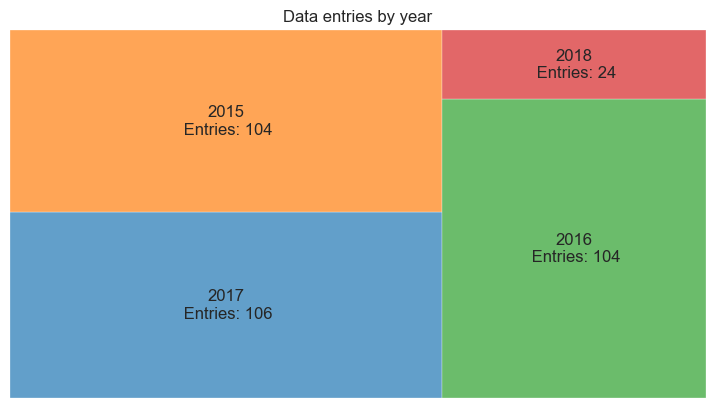

In [1640]:
year_count = df["year"].value_counts()
labels = [f"{year}\n Entries: {count}" for year, count in zip(year_count.index, year_count.values)]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]

plt.figure(figsize=(8, 4))
plt.title("Data entries by year")

# Passe as cores personalizadas para a função squarify.plot
squarify.plot(sizes=year_count.values, label=labels, alpha=0.7, color=colors)

plt.axis('off')  # Remove os eixos
plt.show()

2018 has less data, we don't have the hole year

2016 and 2015 have 52 weeks each (double the data because we're dealing with two types)

2017 has 53 weeks? -> analyze that

Week min for 2015 :  1
First date:  2015-01-04 00:00:00 

Week max for 2015 :  52
Last Date:  2015-12-27 00:00:00 

Week min for 2016 :  1
First date:  2016-01-03 00:00:00 

Week max for 2016 :  53
Last Date:  2016-12-25 00:00:00 

Week min for 2017 :  1
First date:  2017-01-01 00:00:00 

Week max for 2017 :  52
Last Date:  2017-12-31 00:00:00 



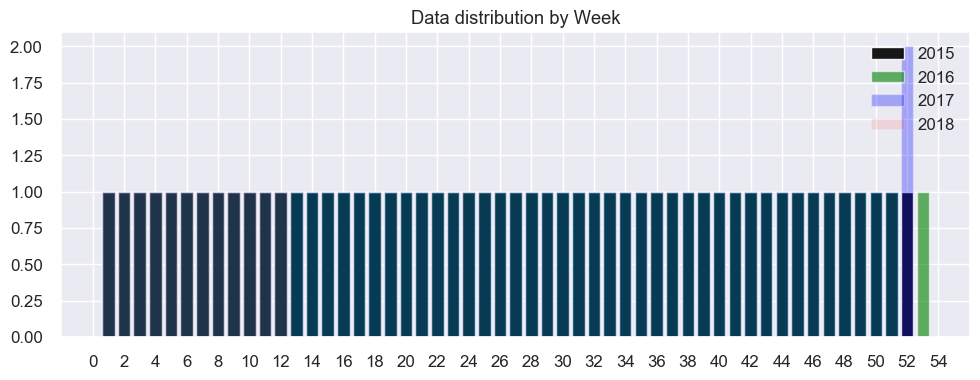

In [1641]:
# 2015
print(f"Week min for 2015 : ", df_conv[df_conv['year'] == 2015]['week'].min())
print(f"First date: ", df_conv[df_conv['year'] == 2015]['date'].min(),"\n")
print(f"Week max for 2015 : ", df_conv[df_conv['year'] == 2015]['week'].max())
print(f"Last Date: ", df_conv[df_conv['year'] == 2015]['date'].max(),"\n")

# 2016
print(f"Week min for 2016 : ", df_conv[df_conv['year'] == 2016]['week'].min())
print(f"First date: ", df_conv[df_conv['year'] == 2016]['date'].min(),"\n")


print(f"Week max for 2016 : ", df_conv[df_conv['year'] == 2016]['week'].max())
print(f"Last Date: ", df_conv[df_conv['year'] == 2016]['date'].max(),"\n")


# 2017
print(f"Week min for 2017 : ", df_conv[df_conv['year'] == 2017]['week'].min())
print(f"First date: ", df_conv[df_conv['year'] == 2017]['date'].min(),"\n")

print(f"Week max for 2017 : ", df_conv[df_conv['year'] == 2017]['week'].max())
print(f"Last Date: ", df_conv[df_conv['year'] == 2017]['date'].max(),"\n")

weeks_15 = df_conv['week'].loc[df_conv['year']==2015].value_counts()
weeks_16 = df_conv['week'].loc[df_conv['year']==2016].value_counts()
weeks_17 = df_conv['week'].loc[df_conv['year']==2017].value_counts()
weeks_18 = df_conv['week'].loc[df_conv['year']==2018].value_counts()

# Create a single plot with all the data
plt.figure(figsize=(10, 4))
sns.set(font_scale=1.1)
listOf_Xticks = np.arange(0, 55, 2)
plt.xticks(listOf_Xticks)
plt.title("Data distribution by Week")

plt.bar(list(weeks_15.keys()), list(weeks_15.values), label='2015', color='black', alpha=0.9)
plt.bar(list(weeks_16.keys()), list(weeks_16.values), label='2016', color='green', alpha=0.6)
plt.bar(list(weeks_17.keys()), list(weeks_17.values), label='2017', color='blue', alpha=0.3)
plt.bar(list(weeks_18.keys()), list(weeks_18.values), label='2018', color='red', alpha=0.1)

plt.legend(loc=1)
plt.grid(True)
plt.tight_layout()

In [1642]:
weeks_15.values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int64)

In [1643]:
#data_array = [weeks_15.values, weeks_16.values, weeks_17.values, weeks_18.values]
#
## Create a single plot with all the data
#plt.figure(figsize=(10, 4))
#sns.set(font_scale=1.1)
#listOf_Xticks = np.arange(0, 55, 2)
#plt.xticks(listOf_Xticks)
#plt.title("Data distribution by Week")
#
#plt.bar(list(weeks_15.keys()), data_array[0], label='2015', color='black', alpha=0.9)
#bottom = data_array[0]
#for i in range(1, 5):
#    plt.bar(list(weeks_15.keys()), data_array[i], bottom=bottom, label=f'Dataset {i + 1}')
#    bottom += data_array[i]
#
#plt.legend(loc=1)
#plt.grid(True)
#plt.tight_layout()

Volume analysis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


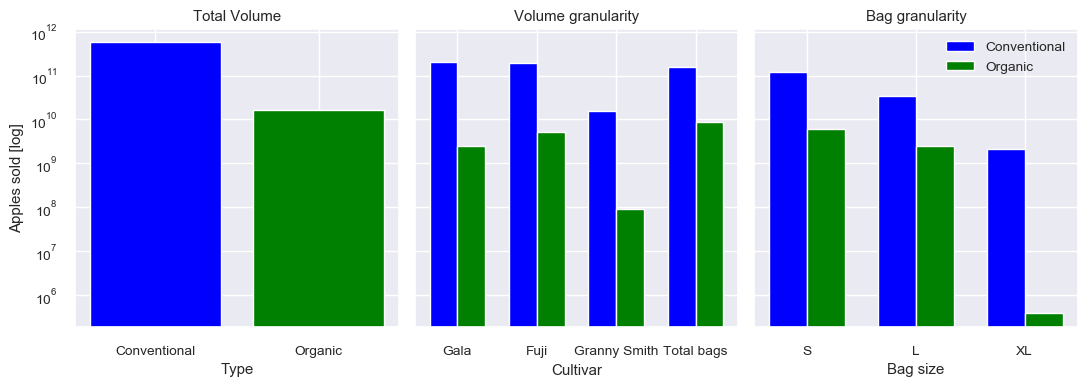

In [1644]:
sns.set(font_scale=0.9)

type = df['type'].unique()
cultivar = ['Gala', 'Fuji', 'Granny Smith', 'Total bags']
bag_size = ['S', 'L', 'XL']
values_1 = [df_conv['total_volume'].sum(), df_org['total_volume'].sum()]
values_2_group_1 = [df_conv['gala'].sum(), df_conv['fuji'].sum(), df_conv['granny_smith'].sum(), df_conv['total_bags'].sum()]
values_2_group_2 = [df_org['gala'].sum(), df_org['fuji'].sum(), df_org['granny_smith'].sum(), df_org['total_bags'].sum()]
values_3_group_1 = [df_conv['s_bags'].sum(), df_conv['l_bags'].sum(), df_conv['xl_bags'].sum()]
values_3_group_2 = [df_org['s_bags'].sum(), df_org['l_bags'].sum(), df_org['xl_bags'].sum()]

fig, axs = plt.subplots(1, 3, figsize=(11, 4), sharey=True)
colors = ['blue', 'green']
label = ['Conventional', 'Organic']
# First histogram (Normal bar chart)
axs[0].bar(label, values_1, color=colors)#, bar_width=0.35)
axs[0].set_xlabel('Type')
axs[0].set_ylabel('Apples sold [log]')
axs[0].set_title('Total Volume')
axs[0].set_yscale('log')

# Second histogram (Grouped bar chart)
bar_width = 0.35
index = np.arange(len(cultivar))
axs[1].bar(index, values_2_group_1, bar_width, color=colors[0], align='center')
axs[1].bar(index + bar_width, values_2_group_2, bar_width, color=colors[1], align='center')
axs[1].set_xlabel('Cultivar')
axs[1].set_title('Volume granularity')
axs[1].set_xticks(index + bar_width / 2)
axs[1].set_xticklabels(cultivar)
axs[1].legend()
axs[1].set_yscale('log')

# Third histogram (Grouped bar chart)
index = np.arange(len(bag_size))
axs[2].bar(index, values_3_group_1, bar_width, label=label[0], color=colors[0], align='center')
axs[2].bar(index + bar_width, values_3_group_2, bar_width, label=label[1], color=colors[1], align='center')
axs[2].set_xlabel('Bag size')
axs[2].set_title('Bag granularity')
axs[2].set_xticks(index + bar_width / 2)
axs[2].set_xticklabels(bag_size)
axs[2].legend()
axs[2].set_yscale('log')

plt.tight_layout()

Price and volume analysis

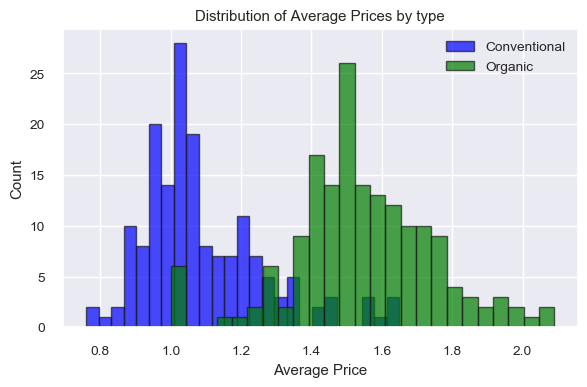

In [1645]:
conventional_data = df[df["type"] == "conventional"]
organic_data = df[df["type"] == "organic"]

plt.figure(figsize=(6, 4))

plt.hist(conventional_data["average_price"], bins=25, edgecolor='k', alpha=0.7, color='blue', label ='Conventional')

plt.hist(organic_data["average_price"], bins=25, edgecolor='k', alpha=0.7, color='green', label = 'Organic')
plt.title("Distribution of Average Prices by type")
plt.xlabel("Average Price")
plt.ylabel("Count")
plt.legend()
plt.grid(True)

plt.tight_layout() 

1.65
0.76
2.09
1.0


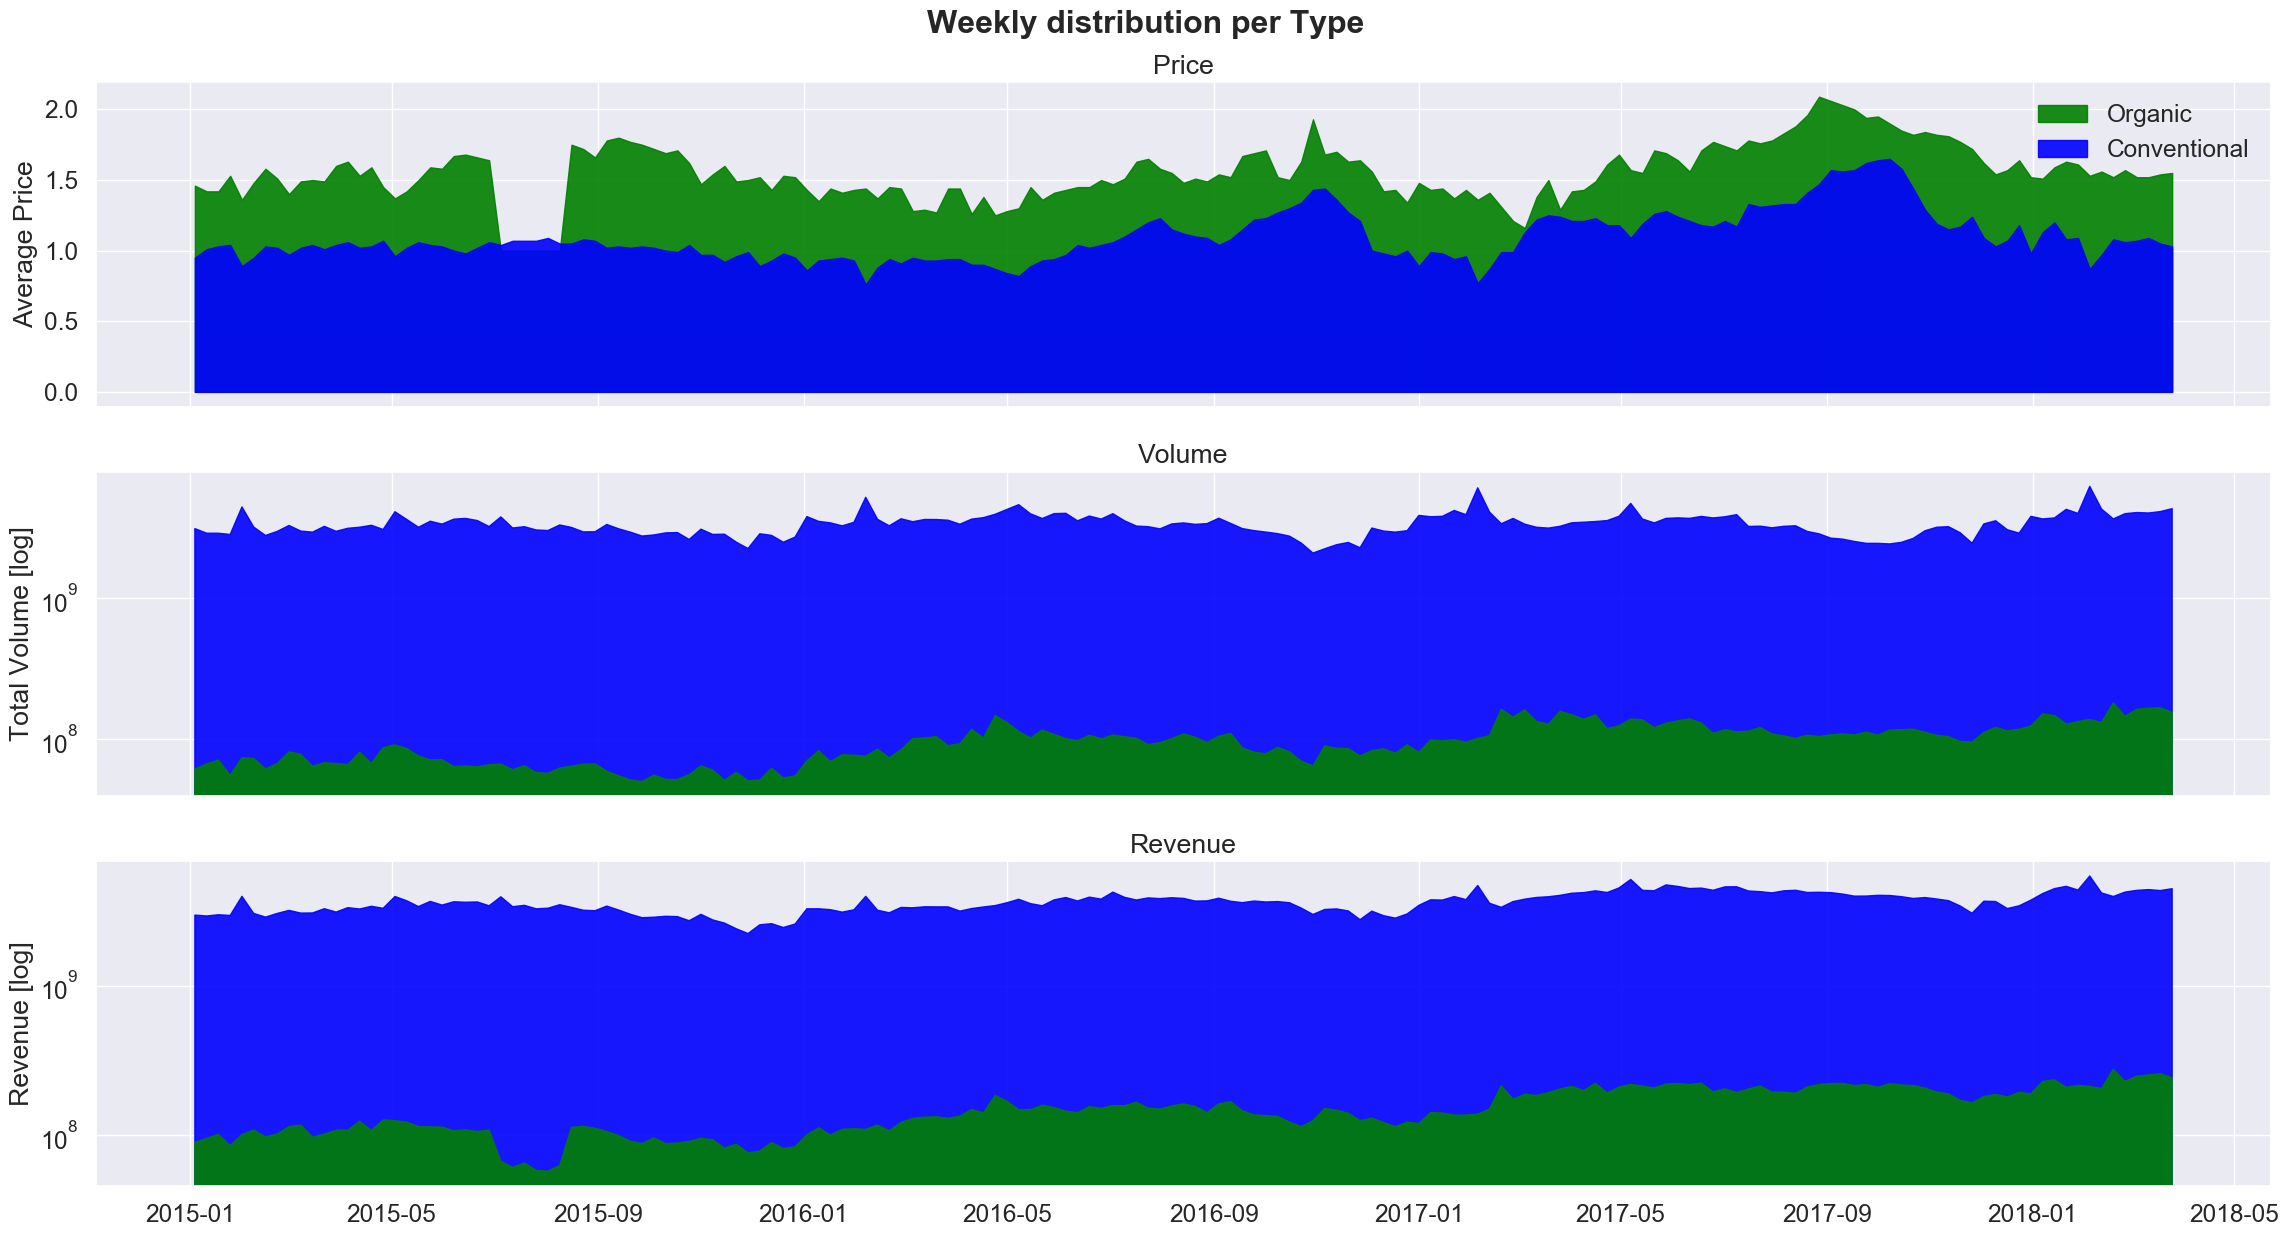

In [1646]:
sns.set(font_scale=1.6)

figure, ax = plt.subplots(3,1,figsize=(25,12))
figure.suptitle("Weekly distribution per Type", y=1.05, fontweight='bold')
ax[0].set_ylabel("Average Price")
ax[1].set_ylabel("Total Volume [log]")
ax[2].set_ylabel("Revenue [log]")
colors = ['blue', 'green']

alpha=0.9
ax[0].fill_between(df_org['date'], df_org['average_price'], label="Organic", color=colors[1], alpha=alpha)
ax[0].fill_between(df_conv['date'], df_conv['average_price'], label="Conventional", color=colors[0], alpha=alpha)
ax[0].set_xticklabels([])
ax[0].legend(loc='upper right')
ax[0].set_title('Price')

ax[1].fill_between(df_conv['date'], df_conv['total_volume'], label="Conventional", color=colors[0], alpha=alpha)
ax[1].fill_between(df_org['date'], df_org['total_volume'], label="Organic", color=colors[1], alpha=alpha)
ax[1].set_xticklabels([])
ax[1].set_yscale('log')
#ax[1].legend(loc='upper right')
ax[1].set_title('Volume')

ax[2].fill_between(df_conv['date'], df_conv['revenue'], label="Conventional", color=colors[0], alpha=alpha)
ax[2].fill_between(df_org['date'], df_org['revenue'], label="Organic", color=colors[1], alpha=alpha)
ax[2].set_yscale('log')
#ax[2].legend(loc='upper right')
ax[2].set_title('Revenue')

print(df_conv['average_price'].max())
print(df_conv['average_price'].min())
print(df_org['average_price'].max())
print(df_org['average_price'].min())

Monthly weighted average prices

In [1647]:
def groupby_month1(d): #Group by month and average the price
    d.loc[:, 'revenue'] = d['average_price'] * d['total_volume']
    d_new = d.groupby('month').agg({'revenue': 'sum', 'total_volume': 'sum'}).reset_index()
    d_new.loc[:, 'w_avgP'] = d_new['revenue']/d_new['total_volume'] #Doesnt fix the problem, but the results are goo
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    d_new['month'] = d_new['month'].apply(lambda x: months[x - 1])
    return d_new #Returns list of average prices for each month

def grafico_fixe1(d): #escolham um melhor nome pls
    years = d['year'].unique()
    for year in years:
        provisoria = groupby_month1(d[d['year']==year])
        sns.scatterplot(x=provisoria['month'], y=provisoria['w_avgP'], label=year)
        plt.plot(provisoria['month'], provisoria['w_avgP'])

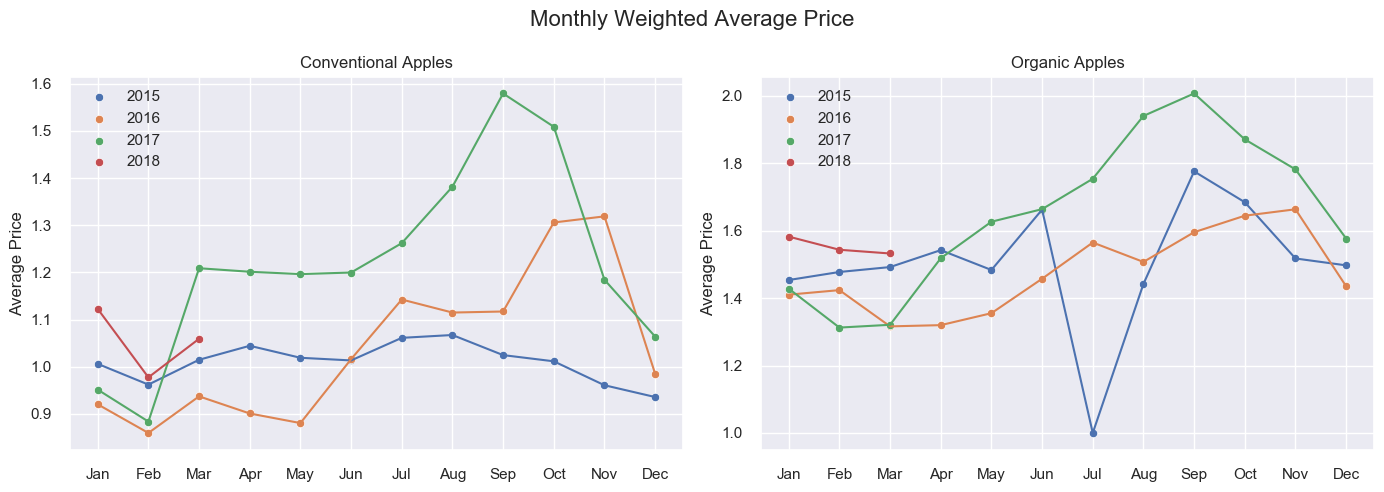

In [1648]:
sns.set(font_scale=1)
plt.figure(figsize=(14, 5))
plt.suptitle('Monthly Weighted Average Price', fontsize=16)

plt.subplot(1, 2, 1) #1st plot
grafico_fixe1(df_conv)
plt.xlabel('')
plt.ylabel("Average Price")
plt.title('Conventional Apples')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2) #2nd plot
grafico_fixe1(df_org)
plt.xlabel('')
plt.ylabel("Average Price")
plt.title('Organic Apples')
plt.legend()
plt.tight_layout()

Monthly total of volume by month

In [1649]:
def groupby_month2(d): #Group by month and average the price
    d_new = d.groupby('month')['total_volume'].sum().reset_index()
    months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    d_new['month'] = d_new['month'].apply(lambda x: months[x - 1])
    return d_new #Returns list of average prices for each month

def grafico_fixe2(d): #escolham um melhor nome pls
    years = d['year'].unique()
    for year in years:
        provisoria = groupby_month2(d[d['year']==year])
        sns.scatterplot(x=provisoria['month'], y=provisoria['total_volume'], label=year)
        plt.plot(provisoria['month'], provisoria['total_volume'])

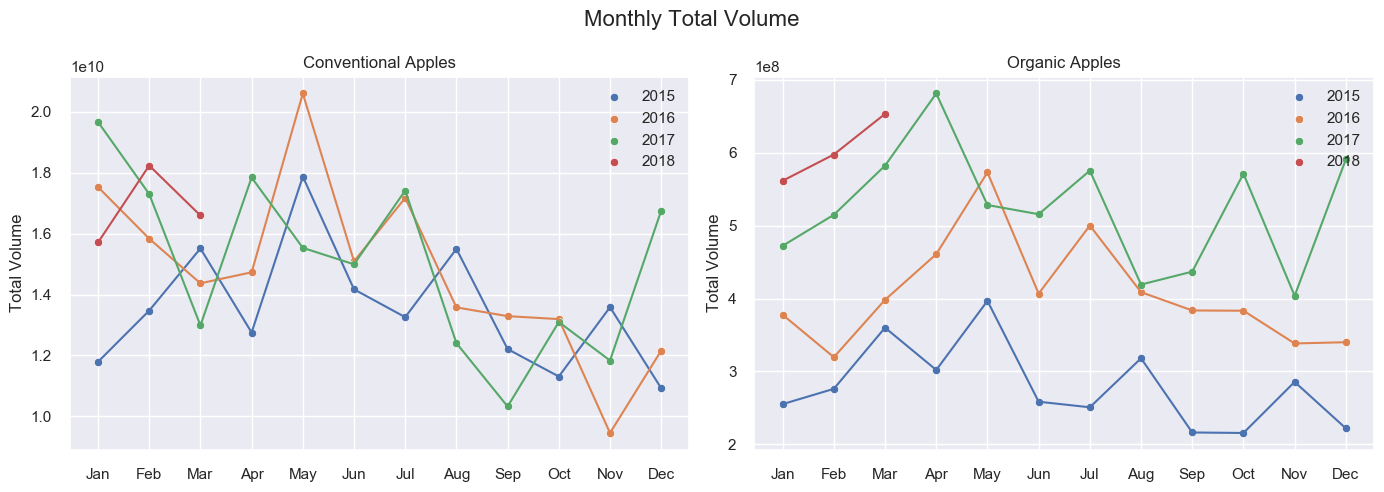

In [1650]:
plt.figure(figsize=(14, 5))
plt.suptitle('Monthly Total Volume', fontsize=16)

plt.subplot(1, 2, 1) #1st plot
grafico_fixe2(df_conv)
plt.xlabel('')
plt.ylabel('Total Volume')
plt.title('Conventional Apples')
plt.legend()

plt.subplot(1, 2, 2) #2nd plot
grafico_fixe2(df_org)
plt.xlabel('')
plt.ylabel('Total Volume')
plt.title('Organic Apples')
plt.legend(loc='upper right')
plt.tight_layout()

What about that concentration of avg_price = 1.0 in organics around Jul-2015?

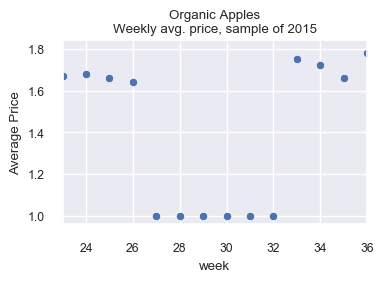

In [1651]:
def small_graph(provisoria):
    provisoria = df_org[df_org['year']==2015]
    sns.set(font_scale=0.8)
    plt.figure(figsize=(3.5, 2))
    sns.scatterplot(x=provisoria['week'], y=provisoria['average_price'])
    plt.ylabel("Average Price")
    plt.title('Organic Apples\nWeekly avg. price, sample of 2015')
    sns.set(font_scale=0.8)
    plt.xlim(23, 36)

small_graph(df_org)

These values are very suspicious. They were probably imputed to compensate for missing values

Delete suspicious values and imput with KNN imput

In [1652]:
def knn_imputer(df, columns , n):
    imputer = KNNImputer(n_neighbors=n)
    imputer.fit(df[columns])
    df[columns] = imputer.transform(df[columns])
    return df

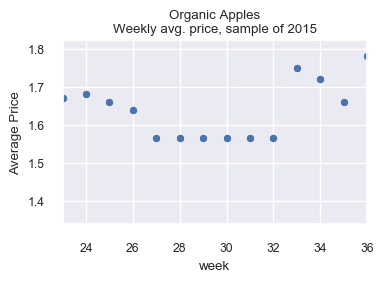

In [1653]:
df_org['average_price'] = df_org['average_price'].replace(1.0, np.nan)
knn_imputer(df_org, ['average_price'], 100)
small_graph(df_org)

Due to having few values they are imputed as the same

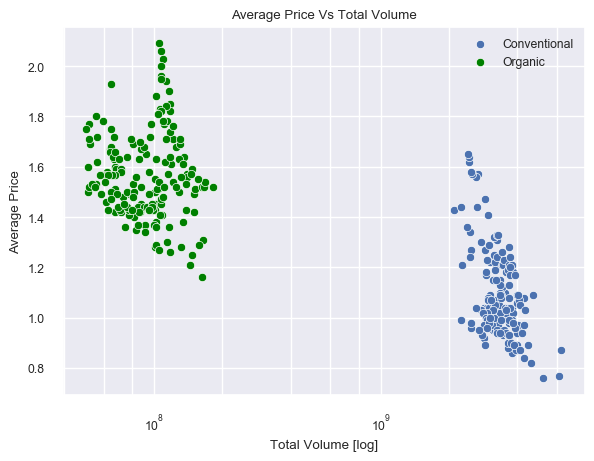

In [1654]:
import matplotlib.ticker as ticker
plt.figure(figsize=(6, 4))
sns.scatterplot(x=df_conv['total_volume'], y=df_conv['average_price'], label='Conventional')
sns.scatterplot(x=df_org['total_volume'], y=df_org['average_price'], label='Organic', color=colors[1])
plt.xscale('log')
#sns.scatterplot(data=df, x='total_volume', y='average_price')
plt.xlabel('Total Volume [log]')
plt.ylabel('Average Price')
plt.title("Average Price Vs Total Volume")
#sns.set(font_scale=1.5)
plt.gca().xaxis.set_minor_locator(ticker.LogLocator(subs=[2, 4, 6, 8]))
plt.grid(True, which='both', axis='both') 

# **3. Models**

In [1655]:
df_conv['target'] = df_conv['average_price'].shift(-1)
df_conv = df_conv.loc[df_conv['target'].notna()].copy().reset_index(drop = True)
#
df_org['target'] = df_org['average_price'].shift(-1)
df_org = df_org.loc[df_org['target'].notna()].copy().reset_index(drop = True)

split_date = pd.to_datetime('2018-01-01')

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

def print_stats(df_set, df):
    print(f'Percentage of original: {len(df_set) / len(df):.0%}')
    print('Target min: {}'.format(df_set["target"].min()))
    print(f'Target median:\t{df_set["target"].median():,.2f}')
    print(f'Target mean:\t{df_set["target"].mean():,.2f}')
    print(f'Target max:\t{df_set["target"].max():,.2f}')

print('\nFull train')
print_stats(df_conv_train, df_conv)
print('\nTest')
print_stats(df_conv_test, df_conv)


Full train
Percentage of original: 93%
Target min: 0.76
Target median:	1.04
Target mean:	1.10
Target max:	1.65

Test
Percentage of original: 7%
Target min: 0.87
Target median:	1.07
Target mean:	1.05
Target max:	1.20


3.1 Baseline: xgboost gradient boost regression

In [1656]:
from xgboost import XGBRegressor

#Hyper-parameters
algo_params = {
    'max_depth': 2, #tree-depth
    'n_estimators': 10, #number of trees
}
algo_params['seed'] = 123 
algo_params['n_jobs'] = -1 #PC config to use all local clusters
algo_params['tree_method'] = 'hist' #histogram-based method for faster training
algo_params['use_label_encoder'] = False #No label encoding for categorical features

#Create instance of regression model with the params
model = XGBRegressor(**algo_params)  #**: dic key-value pairs as keyword args to the constructor 
                                     #-> same thing as explicitly writing each h-param in the function

#### features used
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
]

model.fit( #Training the model
    df_conv_train[numeric_features_used],
    df_conv_train['target']
    )

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=2, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=10, n_jobs=-1, num_parallel_tree=None, predictor=None,
             random_state=None, ...)

Evaluating the model

In [1657]:
from sklearn.metrics import mean_squared_error

def print_score(model, train, test, features):
    preds_train = model.predict(train[features])
    rmse_train = mean_squared_error(train['target'], preds_train, squared = False)

    preds_test = model.predict(test[features])
    rmse_test = mean_squared_error(test['target'], preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print(f'Train score: {rmse_train:,.5f}')
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f} \t||\t Relative overfit: {overfit/rmse_test*100:,.1f}%\n')
    
print_score(model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.05723
Test score: 0.07134 	||	 Overfit: 0.01411 	||	 Relative overfit: 19.8%



In [1658]:
if hasattr(model, 'feature_importances_'):
    feature_importances = model.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
0,average_price,0.736666
4,granny_smith,0.098607
1,total_volume,0.088559
8,xl_bags,0.056487
6,s_bags,0.014243
3,fuji,0.005438
2,gala,0.000000
5,total_bags,0.000000
7,l_bags,0.000000


3.2 Feature Engineering

In [1659]:
#Moving average and STD for average_price
month_size = 4
df_conv['RM_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).mean()
df_conv['STD_avgP_M'] = df_conv['average_price'].rolling(window=month_size, min_periods=0).std()
#
df_org['RM_avgP_M'] = df_org['average_price'].rolling(window=month_size, min_periods=0).mean()
df_org['STD_avgP_M'] = df_org['average_price'].rolling(window=month_size, min_periods=0).std()

#Price elasticity: measure of how price increase affects volume
df_conv['price_elasticity'] = (df_conv['total_volume'].pct_change())/(df_conv['average_price'].pct_change())
#
df_org['price_elasticity'] = (df_org['total_volume'].pct_change())/(df_org['average_price'].pct_change())


numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'month',
    'year',
    'price_elasticity'
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)


xgboost gradient boost regression with grid search

In [1660]:
#Finding the best h-params for Xgboost model by grid search and cross-validation (TimeSeriesSplit)
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import MinMaxScaler

# basic config to be used in all combinations
algo_params['seed'] = 123
algo_params['n_jobs'] = -1
algo_params['tree_method'] = 'hist'
algo_params['use_label_encoder'] = False

#core model
model = XGBRegressor(**algo_params)

#target transformer
target_scale = MinMaxScaler(feature_range = (1, 10000))
target_norm = QuantileTransformer(
    n_quantiles = 100,
    output_distribution = 'normal',
    random_state = 123
)
target_norm = Pipeline([('min', target_scale), ('quantile', target_norm)])

#model inside a pipeline
model = TransformedTargetRegressor(regressor = model, transformer = target_norm)

# params to search for
parameters = {
    'regressor__n_estimators': [8, 10, 12], # 
    'regressor__max_depth': [2, 3, 4],
}

cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

#Trains the model on different combinations of h-params
#Evaluates performance with cv amd chooses the best combination
grid = GridSearchCV(
    estimator = model,
    param_grid = parameters,
    cv = cv_splitter,
    n_jobs = -1,
    refit = True,
)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=TransformedTargetRegressor(regressor=XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=...
                                                                         n_estimators=10,
                                                                         n_jobs=-1,
                                                                         num_parallel_tree=None,
                                                                         predictor=None,
                                                                         random_state=None, ...),
                                                  transformer=Pipeline(steps=[('min',
                                                                               MinMaxScaler(feature_range=(1,
                                                                                                           10000))),
                                                                              ('quantile',
                                                                               QuantileTransformer(n_quantiles=100,
                                                                                                   output_distribution='normal',
                                                                                                   random_state=123))])),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [2, 3, 4],
                         'regressor__n_estimators': [8, 10, 12]})

In [1661]:
#pd.DataFrame(grid.cv_results_)
best_XGBR_conv = grid.best_estimator_
print_score(best_XGBR_conv, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.04152
Test score: 0.09842 	||	 Overfit: 0.05690 	||	 Relative overfit: 57.8%



In [1662]:
feature_importances = best_XGBR_conv.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,average_price,0.395100
9,RM_avgP_M,0.231606
10,STD_avgP_M,0.078387
11,week,0.049163
4,granny_smith,0.047617
6,s_bags,0.035231
8,xl_bags,0.031287
2,gala,0.030698
13,year,0.027604
5,total_bags,0.020225


The feature importance of average price demisnished significantly. The montly moving average seems to have significant importance. Each of the features has a small impact on the model by themselves, but a larger combined importance.

Error Analyses

In [1663]:
def error_analysis(df_test, features, model):
    df_error = df_test.copy()

    df_error['prediction'] = model.predict(df_error[features])

    df_error['error'] = df_error['prediction'] - df_error['target']
    df_error['abs_error'] = df_error['error'].abs()
    n_bins = 4
    df_error['error_bin'] = pd.cut(df_error['abs_error'], n_bins).apply(lambda x: x.mid).astype('float')

    #df_error.tail(5)

    fig, axs = plt.subplots(2, 2, figsize=(10, 6))

    # First subplot
    axs[0, 0].scatter(df_error['target'], df_error['error'])
    axs[0, 0].set_xlabel('Target')
    axs[0, 0].set_ylabel('Error = Prediction - Target')
    axs[0, 0].set_title('Real Error')

    # Second subplot
    axs[0, 1].scatter(df_error['target'], df_error['abs_error'])
    axs[0, 1].set_xlabel('Target')
    axs[0, 1].set_ylabel('|Error|')
    axs[0, 1].set_title('Absolute Error')

    # Third subplot
    axs[1, 0].scatter(df_error['target'], df_error['error_bin'])
    axs[1, 0].set_xlabel('Target')
    axs[1, 0].set_ylabel('|Error| by bin')
    axs[1, 0].set_title('Error Bin ({} bins)'.format(n_bins))

    # Fourth subplot
    df_error['abs_error'].plot(ax=axs[1, 1])
    axs[1, 1].set_xlabel('Date')
    axs[1, 1].set_ylabel('|Error|')
    axs[1, 1].set_title('Absolute Error')

    # Adjust layout
    plt.tight_layout()

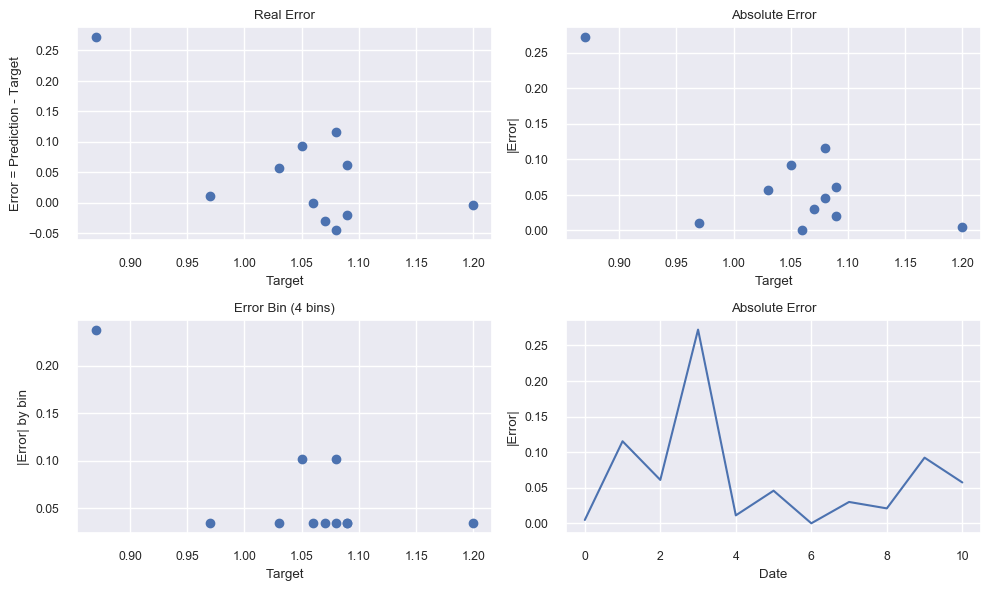

In [1664]:
error_analysis(df_conv_test, numeric_features_used, best_XGBR_conv)

The value of the errors are very similar to each other, except for one value, due to being an anomaly low target

More feature engineering

In [1667]:
#Previous week
df_conv['week_prev'] = df_conv['week'].shift(1) #All correct except the first
df_conv.at[0, 'week_prev'] = 52
df_conv['week_prev'] = df_conv['week_prev'].astype('int32')
#
df_org['week_prev'] = df_org['week'].shift(1) #All correct except the first
df_org.at[0, 'week_prev'] = 52
df_org['week_prev'] = df_org['week_prev'].astype('int32')

#Previous month
df_conv['month_prev'] = df_conv['date'].dt.month -1
df_conv.loc[df_conv['month_prev'] == 0, 'month_prev'] = 12
#
df_org['month_prev'] = df_org['date'].dt.month -1
df_org.loc[df_org['month_prev'] == 0, 'month_prev'] = 12

#Reordering columns
df_conv = df_conv[["date", "average_price", "total_volume", "gala", "fuji", "granny_smith", "total_bags", "s_bags", "l_bags", "xl_bags", "year", "target", "RM_avgP_M", "STD_avgP_M", "price_elasticity", "week", "week_prev", "month", "month_prev"]]
#
df_org = df_org[["date", "average_price", "total_volume", "gala", "fuji", "granny_smith", "total_bags", "s_bags", "l_bags", "xl_bags", "year", "target", "RM_avgP_M", "STD_avgP_M", "price_elasticity", "week", "week_prev", "month", "month_prev"]]

#Two extra moving averages due to the importance of the monthly moving average
alpha = 2/(month_size+1)
df_conv['EMA_avgP_M'] = df_conv['average_price'].ewm(span=month_size, adjust=False).mean() #exponentional moving average
quatrer_size = 13
df_conv['RM_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).mean()
df_conv['STD_avgP_Q'] = df_conv['average_price'].rolling(window=quatrer_size, min_periods=0).std()
df_conv['Lag_Price_4'] = df_conv['average_price'].shift(4)
#
df_org['EMA_avgP_M'] = df_org['average_price'].ewm(span=month_size, adjust=False).mean() #exponentional moving average
df_org['RM_avgP_Q'] = df_org['average_price'].rolling(window=quatrer_size, min_periods=0).mean()
df_org['STD_avgP_Q'] = df_org['average_price'].rolling(window=quatrer_size, min_periods=0).std()
df_org['Lag_Price_4'] = df_org['average_price'].shift(4)

Repeating the model

In [1668]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price_4',
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_XGBR_conv = grid.best_estimator_

print_score(best_XGBR_conv, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.03476
Test score: 0.09196 	||	 Overfit: 0.05719 	||	 Relative overfit: 62.2%



In [1669]:
feature_importances = best_XGBR_conv.regressor_.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,average_price,0.274119
9,RM_avgP_M,0.248574
18,STD_avgP_Q,0.079928
10,STD_avgP_M,0.061040
12,week_prev,0.050799
11,week,0.040094
17,EMA_avgP_M,0.038924
15,year,0.025827
5,total_bags,0.025521
14,month_prev,0.024337


Last iteration of gradient boost, with the features that yielded the highest importance

Train score: 0.05089
Test score: 0.05768 	||	 Overfit: 0.00679 	||	 Relative overfit: 11.8%



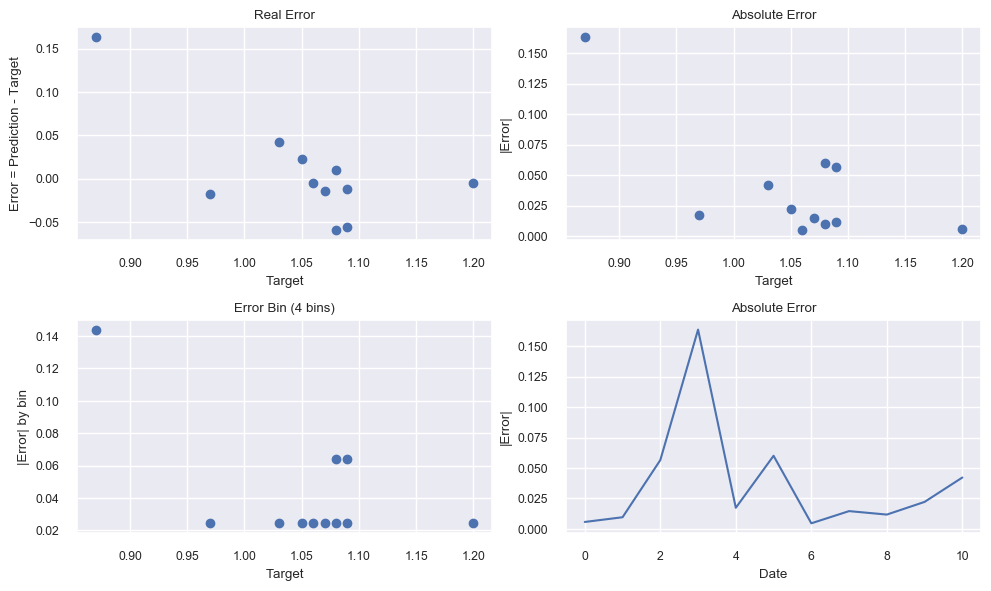

In [1670]:
numeric_features_used = [
    'average_price',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'STD_avgP_Q',
]

#Spliting into training and test data
df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

best_XGBR_conv = grid.best_estimator_

print_score(best_XGBR_conv, df_conv_train, df_conv_test, numeric_features_used)
error_analysis(df_conv_test, numeric_features_used, best_XGBR_conv)

Training for organic apples

Train score: 0.05716
Test score: 0.07243 	||	 Overfit: 0.01527 	||	 Relative overfit: 21.1%



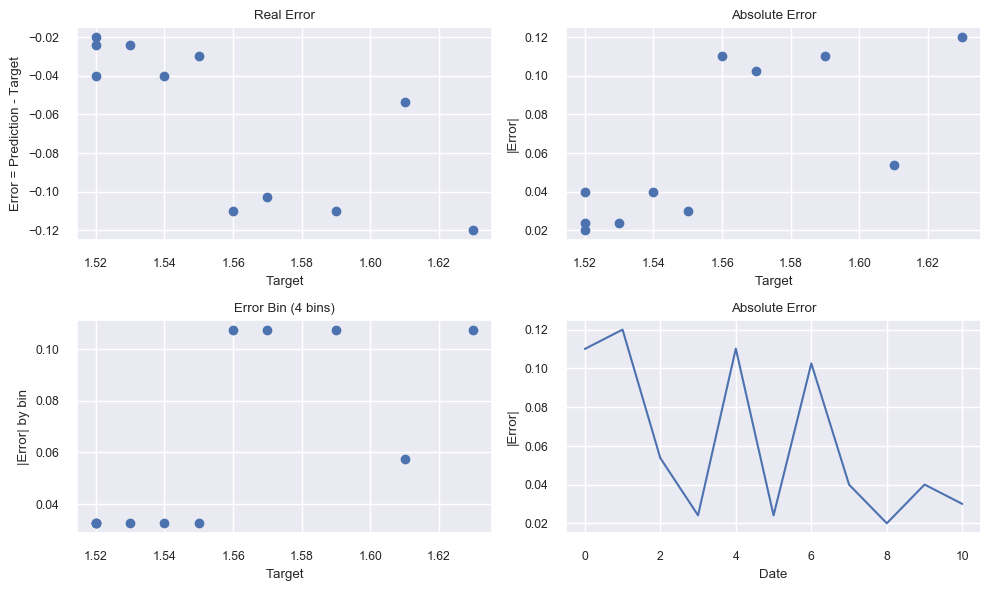

In [1674]:
df_org_train = df_org.loc[df_org['date'] < split_date].copy().reset_index(drop=True)
df_org_test = df_org.loc[df_org['date'] >= split_date].copy().reset_index(drop=True)

grid.fit(
    df_org_train[numeric_features_used],
    df_org_train['target'],
)

best_XGBR_org = grid.best_estimator_

print_score(best_XGBR_org, df_org_train, df_org_test, numeric_features_used)
error_analysis(df_org_test, numeric_features_used, best_XGBR_org)

## Predict!

In [1675]:
last_row = df_conv.tail(1)
pred_XGBR = best_XGBR_conv.predict(last_row[numeric_features_used])
print(f'Next week value for conventional: {pred_XGBR[0]:,.3f}')
#
last_row = df_org.tail(1)
pred_XGBR = best_XGBR_org.predict(last_row[numeric_features_used])
print(f'Next week value for organic: {pred_XGBR[0]:,.3f}')


Next week value for conventional: 1.072
Next week value for organic: 1.520


3.3 RF

Creating extra features

In [1676]:
#Moving averages
df_conv['RM_avgP_8'] = df_conv['average_price'].rolling(window=8, min_periods=0).mean()
df_conv['RM_avgP_26'] = df_conv['average_price'].rolling(window=26, min_periods=0).mean()
df_conv['RM_avgP_52'] = df_conv['average_price'].rolling(window=52, min_periods=0).mean()
#
df_org['RM_avgP_8'] = df_org['average_price'].rolling(window=8, min_periods=0).mean()
df_org['RM_avgP_26'] = df_org['average_price'].rolling(window=26, min_periods=0).mean()
df_org['RM_avgP_52'] = df_org['average_price'].rolling(window=52, min_periods=0).mean()

#Lags
df_conv['Lag_Price_1'] = df_conv['average_price'].shift(1)
df_conv['Lag_Price_8'] = df_conv['average_price'].shift(8)
df_conv['Lag_Price_13'] = df_conv['average_price'].shift(13)
df_conv['Lag_Price_26'] = df_conv['average_price'].shift(26)
df_conv['Lag_Price_52'] = df_conv['average_price'].shift(52)
#
df_org['Lag_Price_1'] = df_org['average_price'].shift(1)
df_org['Lag_Price_8'] = df_org['average_price'].shift(8)
df_org['Lag_Price_13'] = df_org['average_price'].shift(13)
df_org['Lag_Price_26'] = df_org['average_price'].shift(26)
df_org['Lag_Price_52'] = df_org['average_price'].shift(52)


#Ratios
df_conv['ratio_gala'] = df_conv['gala']/df_conv['total_volume']
df_conv['ratio_fuji'] = df_conv['fuji']/df_conv['total_volume']
df_conv['ratio_granny'] = df_conv['granny_smith']/df_conv['total_volume']
df_conv['ratio_bags'] = df_conv['total_bags']/df_conv['total_volume']
#
df_org['ratio_gala'] = df_org['gala']/df_conv['total_volume']
df_org['ratio_fuji'] = df_org['fuji']/df_conv['total_volume']
df_org['ratio_granny'] = df_org['granny_smith']/df_conv['total_volume']
df_org['ratio_bags'] = df_org['total_bags']/df_conv['total_volume']

#Trends
df_conv['trend_M'] = df_conv['RM_avgP_M']/df_conv['average_price']
df_conv['trend_8'] = df_conv['RM_avgP_8']/df_conv['average_price']
df_conv['trend_Q'] = df_conv['RM_avgP_Q']/df_conv['average_price']
df_conv['trend_26'] = df_conv['RM_avgP_26']/df_conv['average_price']
df_conv['trend_52'] = df_conv['RM_avgP_52']/df_conv['average_price']
df_conv['trend_EMA'] = df_conv['EMA_avgP_M']/df_conv['average_price']
#
df_org['trend_M'] = df_org['RM_avgP_M']/df_conv['average_price']
df_org['trend_8'] = df_org['RM_avgP_8']/df_conv['average_price']
df_org['trend_Q'] = df_org['RM_avgP_Q']/df_conv['average_price']
df_org['trend_26'] = df_org['RM_avgP_26']/df_conv['average_price']
df_org['trend_52'] = df_org['RM_avgP_52']/df_conv['average_price']
df_org['trend_EMA'] = df_org['EMA_avgP_M']/df_conv['average_price']

In [1679]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price_1',
    'Lag_Price_4',
    'Lag_Price_8',
    'Lag_Price_13',
    'Lag_Price_26',
    'Lag_Price_52',
    'RM_avgP_8',
    'RM_avgP_26',
    'RM_avgP_52',
    'ratio_gala',
    'ratio_fuji',
    'ratio_granny',
    'ratio_bags',
    'trend_M',
    'trend_8',
    'trend_Q',
    'trend_26',
    'trend_52',
    'trend_EMA',
]

columns_to_imput = ['STD_avgP_M', 'STD_avgP_Q', 'Lag_Price_1', 'Lag_Price_4', 'Lag_Price_8', 'Lag_Price_13', 'Lag_Price_13', 'Lag_Price_26', 'Lag_Price_52']
knn_imputer(df_conv, columns_to_imput, 5)

df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

train_X, test_X = df_conv_train[numeric_features_used], df_conv_test[numeric_features_used]
train_Y, test_Y = df_conv_train['target'], df_conv_test['target']

In [1680]:
def print_score2(model, train_X, train_Y, test_X, test_Y):
    preds_train = model.predict(train_X)
    rmse_train = mean_squared_error(train_Y, preds_train, squared = False)

    preds_test = model.predict(test_X)
    rmse_test = mean_squared_error(test_Y, preds_test, squared = False)

    overfit = rmse_test - rmse_train

    print(f'Train score: {rmse_train:,.5f}\n')
    print(f'Test score: {rmse_test:,.5f} \t||\t Overfit: {overfit:,.5f}  \t||\t Relative overfit: {overfit/rmse_test*100:,.1f}%\n')

In [1684]:
# Define the hyperparameters to search
parameters = {
    'n_estimators': [15, 20, 25], #Tlvz por mais alto depois
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [0.05, 0.07],
    'max_features': [3],
    'bootstrap': [True]
}

# Create the RandomForestRegressor model
RF = RandomForestRegressor()

# Use GridSearchCV for hyperparameter tuning
grid = GridSearchCV(
    estimator=RF, 
    param_grid=parameters, 
    cv=cv_splitter)
    #refit=True)

# Fit the model with training data (you may need to adjust the data)
grid.fit(train_X, train_Y)
best_RF_conv = grid.best_estimator_

print_score2(best_RF_conv, train_X, train_Y, test_X, test_Y)

Train score: 0.04964

Test score: 0.07093 	||	 Overfit: 0.02129  	||	 Relative overfit: 30.0%



In [1685]:
feature_importances = best_RF_conv.feature_importances_

feature_importance_df = pd.DataFrame({'Feature': numeric_features_used, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

feature_importance_df

,Feature,Importance
0,average_price,0.131444
9,RM_avgP_M,0.109469
16,EMA_avgP_M,0.083699
18,RM_avgP_Q,0.068974
35,trend_26,0.065281
20,Lag_Price_4,0.047870
33,trend_8,0.046117
36,trend_52,0.042778
25,RM_avgP_8,0.038514
4,granny_smith,0.037797


Running RF again, with the features rated the highest

In [1708]:
numeric_features_used = [
    'average_price',
    'RM_avgP_M',
    'EMA_avgP_M',
    'RM_avgP_Q',
    'trend_26',
    'Lag_Price_4',
    'trend_8',
    'trend_52',
    'RM_avgP_8',
    'granny_smith',
    'year',    
]

train_X, test_X = df_conv_train[numeric_features_used], df_conv_test[numeric_features_used]
train_Y, test_Y = df_conv_train['target'], df_conv_test['target']

In [1701]:
grid = GridSearchCV(
    estimator=RF, 
    param_grid=parameters, 
    cv=cv_splitter)
    #refit=True)

grid.fit(train_X, train_Y)
best_RF_conv = grid.best_estimator_

print_score2(best_RF_conv, train_X, train_Y, test_X, test_Y)

Train score: 0.05275

Test score: 0.07383 	||	 Overfit: 0.02108  	||	 Relative overfit: 28.6%



In [ ]:
error_analysis()

In [1710]:
knn_imputer(df_org, columns_to_imput, 5)

df_org_train = df_org.loc[df_org['date'] < split_date].copy().reset_index(drop=True)
df_org_test = df_org.loc[df_org['date'] >= split_date].copy().reset_index(drop=True)

train_X, test_X = df_org_train[numeric_features_used], df_org_test[numeric_features_used]
train_Y, test_Y = df_org_train['target'], df_org_test['target']

parameters = {
    'n_estimators': [15, 20, 25], #Tlvz por mais alto depois
    'max_depth': [3, 4, 5, 6],
    'min_samples_split': [0.05, 0.07],
    'max_features': [3],
    'bootstrap': [True]
}

# Create the RandomForestRegressor model
RF = RandomForestRegressor()

# Use GridSearchCV for hyperparameter tuning
grid = GridSearchCV(
    estimator=RF, 
    param_grid=parameters, 
    cv=cv_splitter)
    #refit=True)

grid.fit(train_X, train_Y)
best_RF_org = grid.best_estimator_

print_score2(best_RF_org, train_X, train_Y, test_X, test_Y)

Train score: 0.07304

Test score: 0.03820 	||	 Overfit: -0.03484  	||	 Relative overfit: -91.2%



## Predict

In [1711]:
last_row = df_conv.tail(1)
pred_RF = best_RF_conv.predict(last_row[numeric_features_used])
print(f'Next weeks value conventional: {pred_RF[0]:,.3f}')
#
last_row = df_org.tail(1)
pred_RF = best_RF_org.predict(last_row[numeric_features_used])
print(f'Next weeks value: {pred_RF[0]:,.3f}')

Next weeks value conventional: 1.045
Next weeks value: 1.544


## 3.3 Testing if there are other appropriate models

In [ ]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price_1',
    'Lag_Price_4',
    'Lag_Price_8',
    'Lag_Price_13',
    'Lag_Price_26',
    'Lag_Price_52',
    'RM_avgP_8',
    'RM_avgP_26',
    'RM_avgP_52',
    'ratio_gala',
    'ratio_fuji',
    'ratio_granny',
    'ratio_bags',
    'trend_M',
    'trend_8',
    'trend_Q',
    'trend_26',
    'trend_52',
    'trend_EMA',
]

In [872]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price',
]

In [873]:
regressors = [
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge(),
    SVR(),
]

def best_model(modelos, train, test, features):
    for model in modelos:
        model.fit(train[features], train['target'])
        print(model)
        print_score(model, train, test, numeric_features_used)

best_model(regressors, df_conv_train, df_conv_test, numeric_features_used)

KNeighborsRegressor()


Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542 	||	 Relative overfit: -32.7%

GradientBoostingRegressor()
Train score: 0.01519
Test score: 0.10362 	||	 Overfit: 0.08842 	||	 Relative overfit: 85.3%

KNeighborsRegressor()
Train score: 0.10306
Test score: 0.07763 	||	 Overfit: -0.02542 	||	 Relative overfit: -32.7%

ExtraTreesRegressor()
Train score: 0.00000
Test score: 0.10365 	||	 Overfit: 0.10365 	||	 Relative overfit: 100.0%

RandomForestRegressor()
Train score: 0.02416
Test score: 0.09569 	||	 Overfit: 0.07153 	||	 Relative overfit: 74.7%

DecisionTreeRegressor()
Train score: 0.00000
Test score: 0.12281 	||	 Overfit: 0.12281 	||	 Relative overfit: 100.0%

LinearRegression()
Train score: 0.05222
Test score: 0.09706 	||	 Overfit: 0.04484 	||	 Relative overfit: 46.2%

Lasso()
Train score: 0.11752
Test score: 0.15124 	||	 Overfit: 0.03372 	||	 Relative overfit: 22.3%

Ridge()
Train score: 0.06405
Test score: 0.11125 	||	 Overfit: 0.04720 	||	 Relative overfit: 42.4%

SV

c:\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.202e-01, tolerance: 4.988e-04



# SVR

Even tho the metrics for the SVR are not good we are going to apply this method because it is a good model for small data sets

In [1418]:
#Creating extra features for the SVR

#Moving averages
df_conv['RM_avgP_8'] = df_conv['average_price'].rolling(window=8, min_periods=0).mean()
df_conv['RM_avgP_26'] = df_conv['average_price'].rolling(window=26, min_periods=0).mean()
df_conv['RM_avgP_52'] = df_conv['average_price'].rolling(window=52, min_periods=0).mean()

#Lags
df_conv['Lag_Price_1'] = df_conv['average_price'].shift(1)
df_conv['Lag_Price_8'] = df_conv['average_price'].shift(8)
df_conv['Lag_Price_13'] = df_conv['average_price'].shift(13)
df_conv['Lag_Price_26'] = df_conv['average_price'].shift(26)
df_conv['Lag_Price_52'] = df_conv['average_price'].shift(52)

#Ratios
df_conv['ratio_gala'] = df_conv['gala']/df_conv['total_volume']
df_conv['ratio_fuji'] = df_conv['fuji']/df_conv['total_volume']
df_conv['ratio_granny'] = df_conv['granny_smith']/df_conv['total_volume']
df_conv['ratio_bags'] = df_conv['total_bags']/df_conv['total_volume']

#Trends
df_conv['trend_M'] = df_conv['RM_avgP_M']/df_conv['average_price']
df_conv['trend_8'] = df_conv['RM_avgP_8']/df_conv['average_price']
df_conv['trend_Q'] = df_conv['RM_avgP_Q']/df_conv['average_price']
df_conv['trend_26'] = df_conv['RM_avgP_26']/df_conv['average_price']
df_conv['trend_52'] = df_conv['RM_avgP_52']/df_conv['average_price']
df_conv['trend_EMA'] = df_conv['EMA_avgP_M']/df_conv['average_price']

In [1423]:
knn_imputer(df_conv, ['STD_avgP_M', 'STD_avgP_Q', 'Lag_Price_1', 'Lag_Price_4', 'Lag_Price_8', 'Lag_Price_13', 'Lag_Price_13', 'Lag_Price_26', 'Lag_Price_52'], 10)

,date,average_price,total_volume,gala,fuji,granny_smith,total_bags,s_bags,l_bags,xl_bags,...,ratio_gala,ratio_fuji,ratio_granny,ratio_bags,trend_M,trend_8,trend_Q,trend_26,trend_52,trend_EMA
0,2015-01-04,0.95,3132427773,1235716134,1362408305,84409332,449894002,358532158,89494563,1867281,...,0.394492,0.434937,0.026947,0.143625,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2015-01-11,1.01,2906354275,1154481053,1213477338,86657466,451738418,378326116,71833387,1578915,...,0.397227,0.417526,0.029817,0.155431,0.970297,0.970297,0.970297,0.970297,0.970297,0.964356
2,2015-01-18,1.03,2904345885,1185813934,1170194780,83130190,465206981,387304126,77109320,793535,...,0.408290,0.402912,0.028623,0.160176,0.967638,0.967638,0.967638,0.967638,0.967638,0.967379
3,2015-01-25,1.04,2847031084,1216744503,1073465282,76802005,480019294,397863690,81292473,863131,...,0.427373,0.377047,0.026976,0.168603,0.968750,0.968750,0.968750,0.968750,0.968750,0.974846
4,2015-02-01,0.89,4465546151,1893303804,1895647974,138151611,538442762,421645203,112107647,4689912,...,0.423980,0.424505,0.030937,0.120577,1.115169,1.105618,1.105618,1.105618,1.105618,1.083488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2018-02-18,1.08,3670988749,1326275142,1049191844,55296973,1240224790,902335168,315115742,22773880,...,0.361286,0.285806,0.015063,0.337845,0.928241,0.972222,0.997863,1.172009,1.153490,0.952431
164,2018-02-25,1.06,4002152876,1382985787,1041546359,72433016,1505187714,1066694278,408139772,30353664,...,0.345560,0.260247,0.018099,0.376095,0.938679,1.000000,1.003628,1.179245,1.176524,0.982241
165,2018-03-04,1.07,4074121405,1443954746,1128930737,57174772,1444061150,1083290744,333921496,26848910,...,0.354421,0.277098,0.014034,0.354447,0.976636,0.983645,0.992811,1.150252,1.164450,0.983836
166,2018-03-11,1.09,4044960312,1408909105,1075803945,70757882,1489489380,1139282889,322955662,27250829,...,0.348312,0.265962,0.017493,0.368233,0.986239,0.952982,0.978829,1.112562,1.140790,0.979471


In [1424]:
df_conv.isna().sum()

date                0
average_price       0
total_volume        0
gala                0
fuji                0
granny_smith        0
total_bags          0
s_bags              0
l_bags              0
xl_bags             0
year                0
target              0
RM_avgP_M           0
STD_avgP_M          0
price_elasticity    1
week                0
week_prev           0
month               0
month_prev          0
EMA_avgP_M          0
RM_avgP_Q           0
STD_avgP_Q          0
Lag_Price_4         0
RM_avgP_8           0
RM_avgP_26          0
RM_avgP_52          0
Lag_Price_1         0
Lag_Price_8         0
Lag_Price_13        0
Lag_Price_26        0
Lag_Price_52        0
ratio_gala          0
ratio_fuji          0
ratio_granny        0
ratio_bags          0
trend_M             0
trend_8             0
trend_Q             0
trend_26            0
trend_52            0
trend_EMA           0
dtype: int64

In [1425]:
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    'week_prev',
    'month',
    'month_prev',
    'year',
    #'price_elasticity',
    'EMA_avgP_M',
    'STD_avgP_Q',
    'RM_avgP_Q',
    'Lag_Price_1',
    'Lag_Price_4',
    'Lag_Price_8',
    'Lag_Price_13',
    'Lag_Price_26',
    'Lag_Price_52',
    'RM_avgP_8',
    'RM_avgP_26',
    'RM_avgP_52',
    'ratio_gala',
    'ratio_fuji',
    'ratio_granny',
    'ratio_bags',
    'trend_M',
    'trend_8',
    'trend_Q',
    'trend_26',
    'trend_52',
    'trend_EMA',
]

df_conv_train = df_conv.loc[df_conv['date'] < split_date].copy().reset_index(drop=True)
df_conv_test = df_conv.loc[df_conv['date'] >= split_date].copy().reset_index(drop=True)

model = SVR()

#target transformer -> porbably not usefull

parameters = {
    'gamma': ['scale', 'auto', 0.1],
    'C': [0.1, 1, 10],
    'kernel': ['linear'],
    'epsilon': [0.7, 0.8, 0.90],
}

grid = GridSearchCV(
    estimator=model,
    param_grid=parameters,
    cv=cv_splitter,
    n_jobs=-1
)

grid.fit(
    df_conv_train[numeric_features_used],
    df_conv_train['target'],
)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=SVR(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.7, 0.8, 0.9],
                         'gamma': ['scale', 'auto', 0.1],
                         'kernel': ['linear']})

In [1427]:
grid_best = pd.DataFrame(grid.cv_results_)
#grid_best.sort_values('rank_test_score')

In [1428]:
best_SVR = grid.best_estimator_
#y_pred = best_SVR.predict(df_conv_test[numeric_features_used])
print_score(best_SVR, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.20913
Test score: 0.17031 	||	 Overfit: -0.03882 	||	 Relative overfit: -22.8%



<h3> Ridge with grid search </h3>

In [64]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

# Define the features you want to use for training
numeric_features_used = [
    'average_price',
    'total_volume',
    'gala',
    'fuji',
    'granny_smith',
    'total_bags',
    's_bags',
    'l_bags',
    'xl_bags',
    'RM_avgP_M',
    'week',
    'month',
    'year',
    #'price_elasticity'
]

# Define the cross-validation strategy
cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

# Create the Ridge model
model = Ridge()

# Define the search space for hyperparameters
search_space_linear = {
    'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Create the GridSearchCV instance
search = GridSearchCV(model, search_space_linear, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv_splitter)

# Fit the search to your training data using the specific features
result = search.fit(df_conv_train[numeric_features_used], df_conv_train['target'])

# Get the best model from the search
best_model = search.best_estimator_

# Now you can print the score or other relevant information
print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)



Train score: 0.05601
Test score: 0.10125 	||	 Overfit: 0.04524 	||	 Relative overfit: 44.7%



In [1242]:

# Define the features you want to use for training
numeric_features_used = [
    'average_price',
    'total_volume',
    #'gala',
    #'fuji',
    #'granny_smith',
    #'total_bags',
    #'s_bags',
    #'l_bags',
    #'xl_bags',
    'RM_avgP_M',
    'STD_avgP_M',
    'week',
    #'week_prev',
    'month',
    #'month_prev',
    'year',
    #'price_elasticity',
    #'EMA_avgP_M',
    #'STD_avgP_Q',
    #'RM_avgP_Q',
    'Lag_Price',
]

# Define the cross-validation strategy
cv_splitter = TimeSeriesSplit(
    n_splits = 3,
    gap = 0,
)

# Create the Ridge model
model = Ridge()

# Define the search space for hyperparameters
search_space_linear = {
    'solver': ['svd', 'cholesky', 'lsqr', 'sag'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100],
    'fit_intercept': [True, False]
}

# Create the GridSearchCV instance
search = GridSearchCV(model, search_space_linear, scoring='neg_mean_absolute_error', n_jobs=-1, cv=cv_splitter)

# Fit the search to your training data using the specific features
result = search.fit(df_conv_train[numeric_features_used], df_conv_train['target'])

# Get the best model from the search
best_model = search.best_estimator_

# Now you can print the score or other relevant information
print_score(best_model, df_conv_train, df_conv_test, numeric_features_used)

Train score: 0.05726
Test score: 0.09752 	||	 Overfit: 0.04026 	||	 Relative overfit: 41.3%



c:\anaconda3\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning:

Ill-conditioned matrix (rcond=7.04969e-23): result may not be accurate.



In [ ]:
#How to predict

prediction = model.predict(df_conv[numeric_features_used]) #Predict using the whole df